In [26]:
import sys
import os
import pandas as pd
from functions_sgp.data_transformations import build_player_stat_df
from functions_sgp.gambling_odds import cnvt_deci_to_prob

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

from functions_nfl.import_nfl_readby_parquet import NFLDataLoader

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..', '..', '..'))
sys.path.append(parent_dir)

from function_library.py_data_engineering.utils import categorize_dataframe_columns
from function_library.py_data_visualizations.eda_plots import correlation_heatmap

## Load Data and Perform Merges

In [27]:
seasons = list(range(2014, 2026))

nfl_data_loader = NFLDataLoader()
pbp_import_df = nfl_data_loader.pbp(seasons)
schedule_import_df = nfl_data_loader.schedule(seasons)
player_weekly_import_df = nfl_data_loader.player_weekly(seasons)
team_weekly_import_df = nfl_data_loader.team_weekly(seasons)
depth_df = nfl_data_loader.depth_charts(seasons, schedule_import_df)
player_weekly_df = player_weekly_import_df.merge(depth_df, how='left', on=['season', 'week', 'team', 'player_id'])
player_stat_df = build_player_stat_df(schedule_df=schedule_import_df, player_weekly_df=player_weekly_df)

## Filter player_stat_df to Quarterbacks who attempted at least 5 passes in a given game

In [28]:
qb_df = player_stat_df[(player_stat_df['position']=='QB') & (player_stat_df['attempts']>5)]
qb_df = qb_df[['game_id', 'season', 'week', 'stadium', 'gameday', 'overtime',
 'away_team', 'away_score', 'home_team', 'home_score', 'result', 'total',
 'team_pts', 'opp_pts', 'team_margin', 'away_moneyline', 'home_moneyline',
 'spread_line', 'total_line',
 'away_qb_id', 'home_qb_id', 'away_qb_name', 'home_qb_name', 'away_coach', 'home_coach',
 'player_id', 'player_name',
 'depth_rank', 'depth_position', 'position',
 'team', 'opponent_team',
 'completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_interceptions',
 'sacks_suffered', 'sack_yards_lost', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
 'passing_first_downs', 'passing_epa', 'passing_cpoe', 'passing_2pt_conversions', 'pacr',
 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions']]
qb_df.to_csv("csv_output/qb_df.csv")

In [ ]:
wr_starters_df = player_stat_df[(player_stat_df['depth_position']=='WR') & (player_stat_df['depth_rank']=='1')]
wr_starters_df = wr_starters_df[['game_id',
 'team', 'opponent_team',
 'player_id', 'player_name',
 'depth_rank', 'depth_position', 'position',
 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
 'racr', 'target_share', 'air_yards_share', 'wopr']]
wr_starters_df.rename(columns={'player_id':'player_id_wr', 'player_name': 'player_name_wr', 'depth_rank': 'depth_rank_wr', 'depth_position': 'depth_position_wr', 'position': 'position_wr'}, inplace=True)
wr_starters_df.to_csv("csv_output/wr_starters_df.csv")

In [ ]:
wr_starters_col_dict = categorize_dataframe_columns(wr_starters_df)
for value in wr_starters_col_dict['string']:
    print(value)

game_id
team
opponent_team
player_id_wr
player_name_wr
depth_rank_wr
depth_position_wr
position_wr


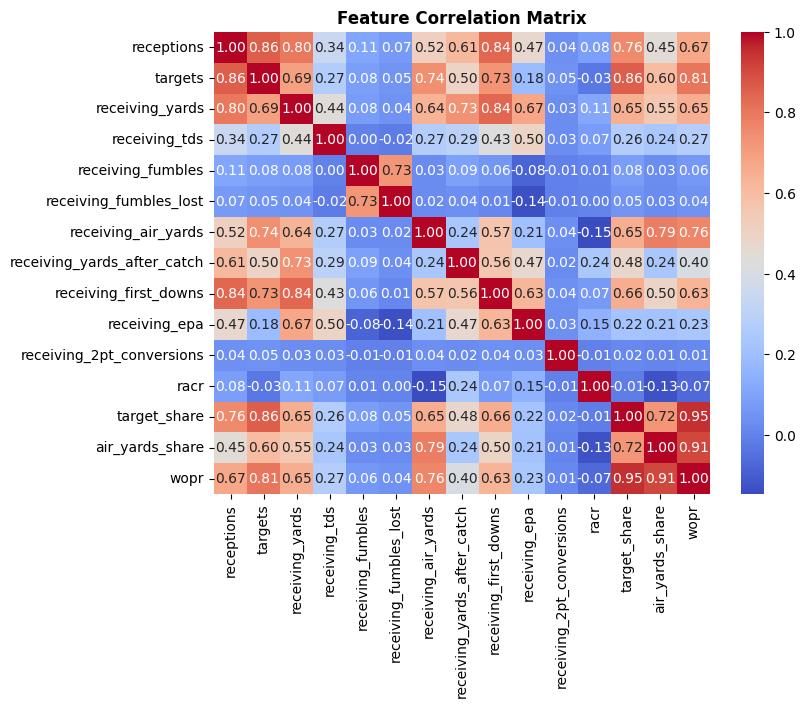

In [ ]:
correlation_heatmap(wr_starters_df, wr_starters_col_dict['float'])

## Incorporate Quarterback and Wide Receiver Statistics Using Conditional Probability Chains

### Conditional Probability Chains (can be adapted to simultaneous events)
    - Even if events are realized at the same time, you can still factor the **joint probability**; this requires that you calculate/estimate the "conditionals" rather than the "full joint"
        - P(A∩B∩C) = P(A) × P(B|A) × P(C|A,B) x P(D|A,B,C)
    - To start, we will look at: P(A) - spread, P(b) - total, P(c) - passing_td, P(d) - receiving_td

### Calculating the P(C) of a QB throwing "n" TD passes based on ALL games where the quarterback's team won by 3.5 points and the total went over 50.5